# Dataset Processing

In [1]:
import pandas as pd
import numpy as np

## Bengali Dataset Reading

In [2]:
ben_df_folder = "/kaggle/input/modified-hate-speech-bengali-hindi/bengali-hate-speech/"
ben_df_dict = {}
ben_df_dict['train'] = pd.read_csv(ben_df_folder + "bengali-hate-speech_train.csv")
ben_df_dict['test'] = pd.read_csv(ben_df_folder + "bengali-hate-speech_test.csv")
ben_df_dict['valid'] = pd.read_csv(ben_df_folder + "bengali-hate-speech_valid.csv")

In [3]:
from datasets import Dataset, DatasetDict

In [4]:
ben_dataset_dict = DatasetDict()
for key in ben_df_dict.keys():
    ben_dataset_dict[key] = Dataset.from_pandas(ben_df_dict[key])

In [5]:
features = ben_dataset_dict['train'].column_names
features.remove('text')
num_features = len(features)
features, num_features

(['defamation', 'hate', 'non-hate', 'violence', 'vulgar'], 5)

In [6]:
id2label = {}
label2id = {}
for i, feature in enumerate(features):
    id2label[str(i)] = feature
    label2id[feature] = i

In [9]:
import tensorflow as tf
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification

2024-05-03 14:43:39.765321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 14:43:39.765459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 14:43:39.881389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    problem_type="multi_label_classification",
    num_labels=num_features,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def tokenize_dataset(dataset):
    encoding = tokenizer(
        dataset['text'],
        padding="max_length",
        max_length=256,
        truncation=True
    )
    labels_batch = {k: dataset[k] for k in dataset.keys() if k in features}
    labels_matrix = np.zeros((len(dataset['text'],), len(features)))
    for idx, label in enumerate(features):
        labels_matrix[:, idx] = labels_batch[label]
    encoding['labels'] = labels_matrix.tolist()
    return encoding

encoded_dataset_dict_tokenized = ben_dataset_dict.map(
    tokenize_dataset,
    batched=True,
    remove_columns=['text'] + features
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/11251 [00:00<?, ? examples/s]

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/3215 [00:00<?, ? examples/s]

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

In [12]:
encoded_dataset_dict_tokenized.set_format(
    type='torch'
)

In [13]:
encoded_dataset_dict_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 11251
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3215
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1607
    })
})

In [14]:
import sklearn.metrics as matrices
from transformers import EvalPrediction

In [15]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    probs = tf.math.sigmoid(predictions)
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = matrices.f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = matrices.roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = matrices.accuracy_score(y_true, y_pred)
    hamming_loss = matrices.hamming_loss(y_true, y_pred)
    jaccard_score = matrices.jaccard_score(y_true, y_pred, average='micro')
    zero_one_loss = matrices.zero_one_loss(y_true, y_pred)
    # return as dictionary
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'hamming_loss': hamming_loss,
        'jaccard_score': jaccard_score,
        'zero_one_loss': zero_one_loss
    }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [16]:
from transformers import TrainingArguments, Trainer

In [17]:
args = TrainingArguments(
    output_dir='./results/',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_dict_tokenized['train'],
    eval_dataset=encoded_dataset_dict_tokenized['valid'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [20]:
import os

In [21]:
files = os.listdir(args.output_dir)
if len(files) == 0:
    trainer.train()
else:
    trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Hamming Loss,Jaccard Score,Zero One Loss,Runtime,Samples Per Second,Steps Per Second
6,0.158300,0.222908,0.797820,0.864326,0.703796,0.092346,0.663645,0.296204,13.761100,116.778000,3.706000
7,0.158300,0.223135,0.804573,0.868882,0.717486,0.089359,0.673042,0.282514,13.214800,121.606000,3.859000
8,0.143700,0.225952,0.802168,0.868282,0.715619,0.090853,0.669683,0.284381,13.216600,121.590000,3.859000
9,0.121500,0.227257,0.805250,0.872813,0.718108,0.090479,0.673991,0.281892,13.115100,122.530000,3.889000
10,0.110400,0.229342,0.801841,0.868306,0.719975,0.091101,0.669227,0.280025,13.183500,121.895000,3.868000


The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 

In [22]:
trainer.evaluate()

{'eval_loss': 0.22725683450698853,
 'eval_f1': 0.8052504687918564,
 'eval_roc_auc': 0.8728132424016339,
 'eval_accuracy': 0.7181082762912259,
 'eval_hamming_loss': 0.09047915370255134,
 'eval_jaccard_score': 0.6739910313901345,
 'eval_zero_one_loss': 0.28189172370877413,
 'eval_runtime': 13.0503,
 'eval_samples_per_second': 123.139,
 'eval_steps_per_second': 3.908,
 'epoch': 10.0}

In [23]:
actual_labels = encoded_dataset_dict_tokenized['test']['labels']
pred_labels = trainer.predict(
    encoded_dataset_dict_tokenized['test']
)

In [24]:
probs = tf.math.sigmoid(pred_labels.predictions)
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= 0.3)] = 1

In [25]:
print('Accuracy Score: ', matrices.accuracy_score(actual_labels, y_pred))
print('F1 Score: ', matrices.f1_score(actual_labels, y_pred, average='micro'))
print('ROC AUC: ', matrices.roc_auc_score(actual_labels, y_pred, average='micro'))
print('Hamming Loss: ', matrices.hamming_loss(actual_labels, y_pred))
print('Jaccard Score: ', matrices.jaccard_score(actual_labels, y_pred, average='micro'))
print('Zero-One Loss:', matrices.zero_one_loss(actual_labels, y_pred))

print('\nClassification Report :-\n',
      matrices.classification_report(
          actual_labels,
          y_pred,
          output_dict=False,
          target_names=features,
      )
     )

Accuracy Score:  0.6746500777604977
F1 Score:  0.7859657947686116
ROC AUC:  0.8742439500922521
Hamming Loss:  0.10587869362363919
Jaccard Score:  0.6474000414336026
Zero-One Loss: 0.3253499222395023

Classification Report :-
               precision    recall  f1-score   support

  defamation       0.62      0.82      0.71       828
        hate       0.53      0.65      0.58       364
    non-hate       0.94      0.91      0.92      1548
    violence       0.62      0.78      0.69       482
      vulgar       0.75      0.83      0.78       511

   micro avg       0.74      0.84      0.79      3733
   macro avg       0.69      0.80      0.74      3733
weighted avg       0.76      0.84      0.79      3733
 samples avg       0.78      0.84      0.79      3733



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
import matplotlib.pyplot as plt

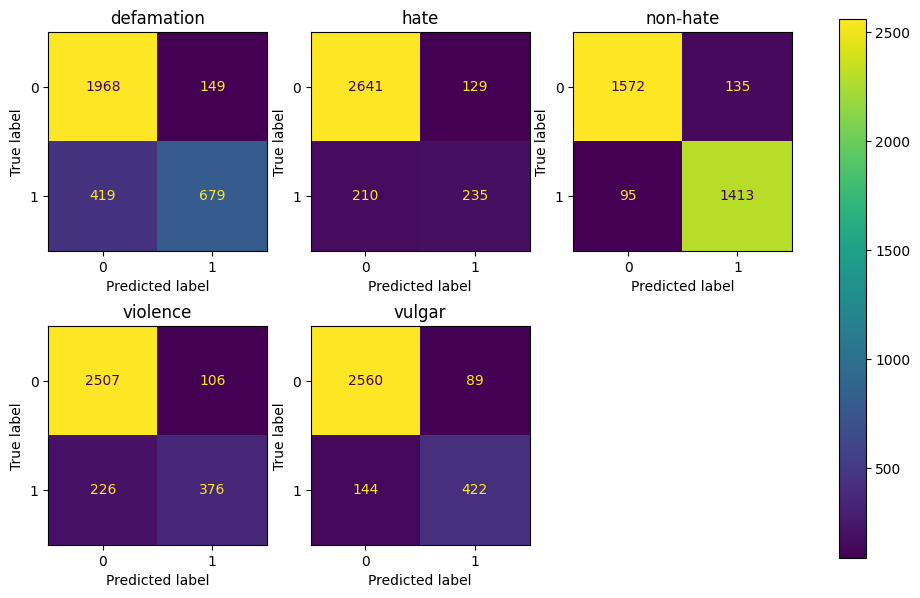

In [27]:
confusion_matrices =  matrices.multilabel_confusion_matrix(
    y_pred,
    actual_labels
)

fig, axis = plt.subplots(2, 3, figsize=(12, 7))
axis = axis.ravel()
for i in range(len(confusion_matrices)):
    disp = matrices.ConfusionMatrixDisplay(
        confusion_matrices[i],
    )
    disp.plot(ax=axis[i], values_format='.4g')
    disp.ax_.set_title(features[i])
    disp.im_.colorbar.remove()
fig.colorbar(disp.im_, ax=axis)
axis[5].remove()

In [28]:
trained_model_name = model_name.split('/')[1] + '-hate-speech-ben-hin-epochs-' + str(args.num_train_epochs)
trainer.save_model('./' + trained_model_name)

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


In [29]:
os.system("cd /kaggle/working/; zip -r "+trained_model_name+".zip ./"+trained_model_name)

  adding: bangla-bert-base-hate-speech-ben-hin-epochs-10/ (stored 0%)
  adding: bangla-bert-base-hate-speech-ben-hin-epochs-10/tokenizer.json (deflated 77%)
  adding: bangla-bert-base-hate-speech-ben-hin-epochs-10/config.json (deflated 52%)
  adding: bangla-bert-base-hate-speech-ben-hin-epochs-10/tokenizer_config.json (deflated 75%)
  adding: bangla-bert-base-hate-speech-ben-hin-epochs-10/vocab.txt (deflated 74%)
  adding: bangla-bert-base-hate-speech-ben-hin-epochs-10/training_args.bin (deflated 51%)
  adding: bangla-bert-base-hate-speech-ben-hin-epochs-10/special_tokens_map.json (deflated 42%)
  adding: bangla-bert-base-hate-speech-ben-hin-epochs-10/model.safetensors (deflated 7%)


0

In [ ]:
os.system("rm -r ./" + trained_model_name)
